# Total precipitation from ERA-INTERIM data set

## Overview

- **Key ideas:**
    - Intensive operations that use a lot of RAM memory. Run this notebook inside one of cluster nodes of `aerossol` server.
    - ERA_INTERIM total precipitation is a fully global historical precipitation dataset (`1979–2018` with `12-hour` temporal and `0.75°` spatial resolutions).
    - Explore single `global` file.
    - Explore all data available for `South America` resampled from `12-houy` to `daily`, `annual`, `semi-monthly`, and `monthly` sums: (1), time series, (2) monthly climatology, and (3) long term ordinary least square `OLS` trends of observed data.
    - No evaluation of statistical significances for OLS trends.

## Initial setup

In [1]:
# Load packages.
import os
import sys
import glob
import warnings
import scipy

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import cartopy.crs as ccrs

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from dask.diagnostics import ProgressBar

warnings.filterwarnings("ignore")
xr.set_options(display_style="text")
%matplotlib inline

In [2]:
print(">>> Versions:")
print("* numpy:", np.__version__)
print("* xarray:", xr.__version__)
print("\n>>> Computer:")
!echo "* Hostname: ${HOSTNAME}"
!echo "* User: ${USER}"
!echo "* Directory: $(pwd)"
!echo "* Date: $(date)"
!echo "* CPUs: $(nproc)"

>>> Versions:
* numpy: 1.19.1
* xarray: 0.16.0

>>> Computer:
* Hostname: n007
* User: sandroal
* Directory: /work/sandroal/notebooks
* Date: Wed Oct 21 15:52:24 BRST 2020
* CPUs: 40


In [3]:
%%time

# My repository.
repository = "/work/sandroal/cdlearn/"

# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Import my package.
import cdlearn

CPU times: user 1.6 s, sys: 428 ms, total: 2.03 s
Wall time: 2.81 s


In [4]:
# Main directory.
MAIN_FOLDER = "/work/sandroal/data_sets/ERA_INTERIM/total_precipitation_daily/"

# Map borders for South America.
loni, lonf, lati, latf = -90, -30, -60, 20

# Final results.
save_fig = True

# Data files location.
FIG_FOLDER = "/work/sandroal/images/single_variables/"

In [5]:
# One file for each year (2001 - 2018). 
FILES_PATHS = sorted(glob.glob(MAIN_FOLDER + "*nc"))

# Show some data files paths.
FILES_PATHS[-5:]

['/work/sandroal/data_sets/ERA_INTERIM/total_precipitation_daily/tp_daily_2018_08.nc',
 '/work/sandroal/data_sets/ERA_INTERIM/total_precipitation_daily/tp_daily_2018_09.nc',
 '/work/sandroal/data_sets/ERA_INTERIM/total_precipitation_daily/tp_daily_2018_10.nc',
 '/work/sandroal/data_sets/ERA_INTERIM/total_precipitation_daily/tp_daily_2018_11.nc',
 '/work/sandroal/data_sets/ERA_INTERIM/total_precipitation_daily/tp_daily_2018_12.nc']

## Explore single global file

In [6]:
%%time

# Random choice of a file.
RFP = np.random.choice(FILES_PATHS)
DS = xr.open_dataset(RFP)

# Show it.
print(DS)

<xarray.Dataset>
Dimensions:    (latitude: 241, longitude: 480, time: 62)
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.75 358.5 359.25
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * time       (time) datetime64[ns] 1981-05-01T12:00:00 ... 1981-06-01
Data variables:
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2019-02-28 01:29:56 GMT by grib_to_netcdf-2.12.0: grib_to_n...
CPU times: user 8 ms, sys: 12 ms, total: 20 ms
Wall time: 20.9 ms


In [7]:
print(">>> Units:", DS.tp.units)
nnans = np.sum(np.isnan(DS.tp.values.flatten()))
size = DS.tp.size
print(">>> Total nans:", nnans, "(%.2f %%)" %(nnans / size * 100))

>>> Units: m
>>> Total nans: 0 (0.00 %)


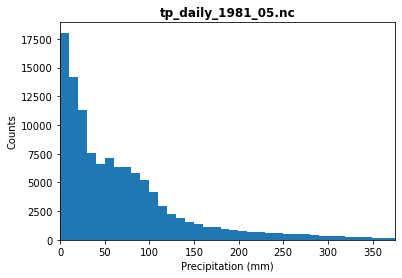

In [8]:
plt.hist((1000 * DS.tp.sum("time")).values.flatten(), bins=100);
plt.ylabel("Counts"); plt.xlabel("Precipitation (mm)")
plt.title(os.path.basename(RFP), weight="bold");
plt.xlim((0, 375));

CPU times: user 2.66 s, sys: 4 ms, total: 2.67 s
Wall time: 2.67 s


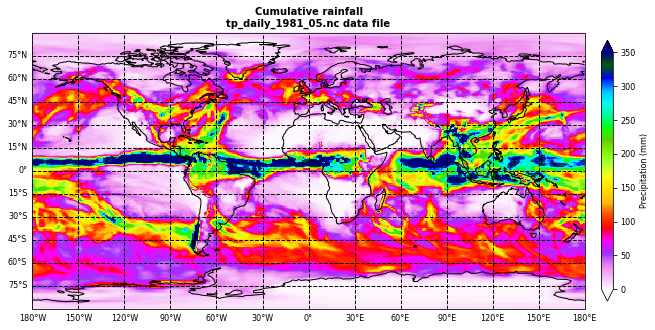

In [9]:
%%time

# Set figure size, projection, and extent.
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90]) 

# Add coastlines and formatted gridlines.
ax.coastlines(resolution="110m", linewidth=1)
gl = ax.gridlines(
    crs=ccrs.PlateCarree(), 
    draw_labels=True, 
    linewidth=1, 
    color="black", 
    linestyle="--"
)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180 + 30, 30))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90 + 15, 15))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {"size": 8, "color": "black"}
gl.ylabel_style = {"size": 8, "color": "black"}

# Draw the plot.
p = (1000 * DS.tp.sum("time")).plot(
    ax=ax,
    vmin=0,
    vmax=350,
    cmap=plt.cm.gist_ncar_r,
    add_colorbar=False,
    add_labels=False
)

# Adjustments.
plt.title(f"Cumulative rainfall\n" + os.path.basename(RFP) + " data file", weight="bold", size=10)
cb = plt.colorbar(
    mappable=p, 
    ax=ax, 
    orientation="vertical", 
    pad=0.025, 
    shrink=0.8,
    extend="both"
)
cb.set_label("Precipitation (mm)", size=8)
cb.ax.tick_params(labelsize=8) 

## Daily data

In [10]:
%%time

# Lazy read.
DS_DAY = xr.open_mfdataset(
    paths=FILES_PATHS,
    concat_dim="time",
    chunks={} 
)

# Sum 12-hour values into daily values.
DS_DAY = DS_DAY.resample({"time": "D"}).sum("time")

# Rename coordinates.
DS_DAY = DS_DAY.rename(name_dict={"latitude": "lat", "longitude": "lon"})

# My ninja way.
DS_DAY = cdlearn.utils.organize_data(DS_DAY)
DS_DAY = cdlearn.utils.shift_longitude(DS_DAY)
DS_DAY = cdlearn.utils.organize_data(DS_DAY)

# South America .
DS_DAY = DS_DAY.sel(lat=slice(lati, latf), lon=slice(loni, lonf))

# From m to mm.
DS_DAY["tp"] = 1000 * DS_DAY.tp

# Show it.
print(DS_DAY)

<xarray.Dataset>
Dimensions:  (lat: 107, lon: 81, time: 14611)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-01-01
  * lon      (lon) float32 -90.0 -89.25 -88.5 -87.75 ... -31.5 -30.75 -30.0
  * lat      (lat) float32 -60.0 -59.25 -58.5 -57.75 ... 17.25 18.0 18.75 19.5
Data variables:
    tp       (time, lat, lon) float32 dask.array<chunksize=(1, 107, 81), meta=np.ndarray>
CPU times: user 1min 15s, sys: 1.08 s, total: 1min 16s
Wall time: 1min 16s


In [11]:
print(">>> Size in GB:", DS_DAY.nbytes / 1e9)

>>> Size in GB: 0.506651788


In [12]:
# Load into memory.
with ProgressBar():
    DS_DAY = DS_DAY.load()

[########################################] | 100% Completed | 40.5s


## Obtain annual cumulative precipitation

In [13]:
%%time

# Monthly resample.
DS_ANU = DS_DAY.resample({"time": "YS"}).sum("time")

# Show it.
print(DS_ANU)

<xarray.Dataset>
Dimensions:  (lat: 107, lon: 81, time: 41)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01
  * lon      (lon) float32 -90.0 -89.25 -88.5 -87.75 ... -31.5 -30.75 -30.0
  * lat      (lat) float32 -60.0 -59.25 -58.5 -57.75 ... 17.25 18.0 18.75 19.5
Data variables:
    tp       (time, lat, lon) float32 948.5466 943.1242 ... -1.4901161e-05
CPU times: user 336 ms, sys: 0 ns, total: 336 ms
Wall time: 336 ms


## Obtain monthly cumulative precipitation

In [14]:
%%time

# Monthly resample.
DS_MON = DS_DAY.resample({"time": "MS"}).sum("time")

# Show it.
print(DS_MON)

<xarray.Dataset>
Dimensions:  (lat: 107, lon: 81, time: 481)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2019-01-01
  * lon      (lon) float32 -90.0 -89.25 -88.5 -87.75 ... -31.5 -30.75 -30.0
  * lat      (lat) float32 -60.0 -59.25 -58.5 -57.75 ... 17.25 18.0 18.75 19.5
Data variables:
    tp       (time, lat, lon) float32 61.20574 62.01936 ... -1.4901161e-05
CPU times: user 796 ms, sys: 0 ns, total: 796 ms
Wall time: 793 ms


## Obtain semi-monthly cumulative precipitation

In [15]:
%%time

# Monthly resample.
DS_SMO = DS_DAY.resample({"time": "SMS"}).sum("time")

# Show it.
print(DS_SMO)

<xarray.Dataset>
Dimensions:  (lat: 107, lon: 81, time: 961)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-15 ... 2019-01-01
  * lon      (lon) float32 -90.0 -89.25 -88.5 -87.75 ... -31.5 -30.75 -30.0
  * lat      (lat) float32 -60.0 -59.25 -58.5 -57.75 ... 17.25 18.0 18.75 19.5
Data variables:
    tp       (time, lat, lon) float32 28.33438 29.76857 ... -1.4901161e-05
CPU times: user 1.15 s, sys: 0 ns, total: 1.15 s
Wall time: 1.14 s


## Time series in a random grid point

In [16]:
%%time

# Random selection of a land grid point (True).
play = True

def pick_one_grid_point():
    loc_lat = np.random.choice(DS_DAY.lat)
    loc_lon = np.random.choice(DS_DAY.lon)
    selection = {"lat": loc_lat, "lon": loc_lon}
    return selection
    
if play:

    selection = pick_one_grid_point()
    suptitle = "Base point for nearest one (lat=%.2f, lon=%.2f)" %(selection["lat"], selection["lon"])
    
else:
    # Select a grid point.
    loc_lat, loc_lon, method = -21.0, -45.0, "nearest"
    selection = {"lat": loc_lat, "lon": loc_lon, "method": method}
    suptitle = "Minas Gerais State, Brazil (lat=%.2f, lon=%.2f)" %(selection["lat"], selection["lon"])

# Show it.
print(">>> Selection:\n", selection)

>>> Selection:
 {'lat': -28.5, 'lon': -35.25}
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 925 µs


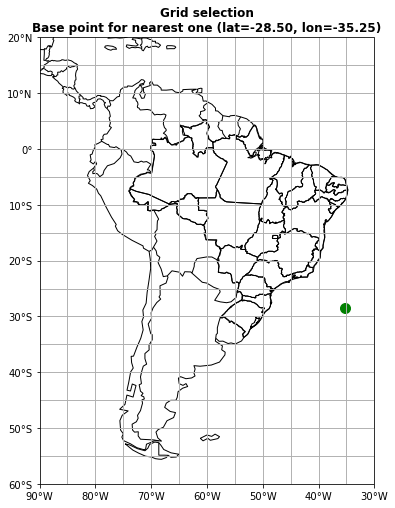

In [17]:
# Map.
axgr = cdlearn.maps.south_america(
    figsize=(6, 12), 
    nrows_ncols=(1, 1),
    titles=["Grid selection\n" + suptitle],
    cbar_mode=None
)

_ = axgr[0].scatter(
    x=selection["lon"], 
    y=selection["lat"], 
    s=100,
    marker="o", 
    color="green",
)

CPU times: user 2.27 s, sys: 240 ms, total: 2.51 s
Wall time: 2.52 s


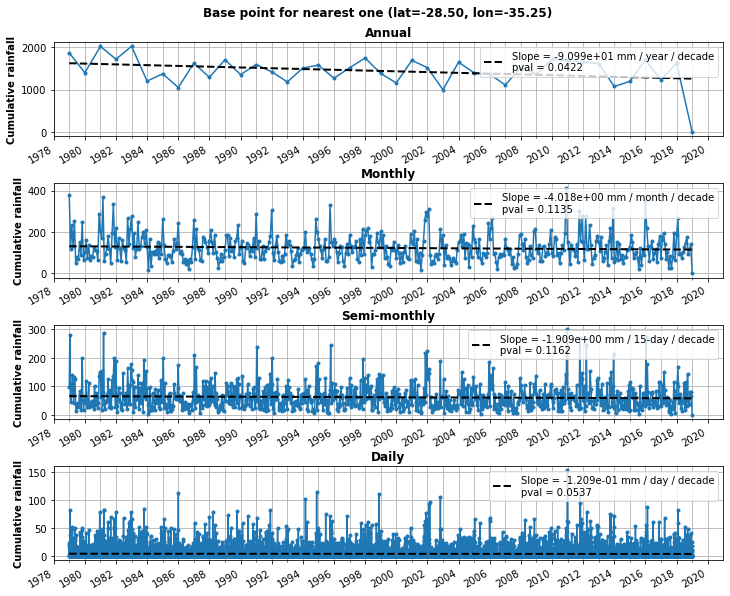

In [18]:
%%time

# Make figure.
fig, axes = plt.subplots(4, 1, figsize=(12, 9))
axes = axes.flatten()

# Time series.
(1 * DS_ANU.tp).sel(**selection).plot(ax=axes[0], marker=".")
(1 * DS_MON.tp).sel(**selection).plot(ax=axes[1], marker=".")
(1 * DS_SMO.tp).sel(**selection).plot(ax=axes[2], marker=".")
(1 * DS_DAY.tp).sel(**selection).plot(ax=axes[3], marker=".")

# Annual linear OLS regression.
Y = (1 * DS_ANU).tp.sel(**selection).values
X = np.arange(Y.shape[0])
slope, intercept, _, p_value, _ = scipy.stats.linregress(X, Y)
axes[0].plot(DS_ANU.time, slope * X + intercept, ls="--", lw=2, color="black",
    label="Slope = %.3e mm / year / decade" %(10 * slope)+ \
          "\npval = %.4f" %(p_value))
    
# Monthly linear OLS regression.
Y = (1 * DS_MON).tp.sel(**selection).values
X = np.arange(Y.shape[0])
slope, intercept, _, p_value, _ = scipy.stats.linregress(X, Y)
axes[1].plot(DS_MON.time, slope * X + intercept, ls="--", lw=2, color="black",
    label="Slope = %.3e mm / month / decade" %(120 * slope)+ \
          "\npval = %.4f" %(p_value))    
    
# Semi-monthly linear OLS regression.
Y = (1 * DS_SMO).tp.sel(**selection).values
X = np.arange(Y.shape[0])
slope, intercept, _, p_value, _ = scipy.stats.linregress(X, Y)
axes[2].plot(DS_SMO.time, slope * X + intercept, ls="--", lw=2, color="black",
    label="Slope = %.3e mm / 15-day / decade" %(240 * slope)+ \
          "\npval = %.4f" %(p_value))     

# Daily linear OLS regression.
Y = (1 * DS_DAY).tp.sel(**selection).values
X = np.arange(Y.shape[0])
slope, intercept, _, p_value, _ = scipy.stats.linregress(X, Y)
axes[3].plot(DS_DAY.time, slope * X + intercept, ls="--", lw=2, color="black",
    label="Slope = %.3e mm / day / decade" %(3650 * slope)+ \
          "\npval = %.4f" %(p_value))  

# Adjustments.
for axis in axes:
    axis.legend(loc=1)
    yi = np.unique(DS_ANU.time.dt.year)[0] - 1
    yf = np.unique(DS_ANU.time.dt.year)[-1]
    axis.grid(which="both")
    axis.xaxis.set_major_locator(mdates.YearLocator(2))
    axis.xaxis.set_minor_locator(mdates.YearLocator(1))
    axis.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    axis.set_xlim(pd.Timestamp(str(yi)), pd.Timestamp(str(yf + 2)))
    axis.set_xticks(pd.date_range(start=str(yi), end=str(yf), freq="1YS"), minor=True)
    axis.set_xlabel(None)
    axis.set_ylabel("Cumulative rainfall", weight="bold")
    
# More adjustments.
axes[0].set_title("Annual", weight="bold")
axes[1].set_title("Monthly", weight="bold")
axes[2].set_title("Semi-monthly", weight="bold")
axes[3].set_title("Daily", weight="bold")
fig.suptitle(suptitle, weight="bold")
plt.subplots_adjust(top=0.925, hspace=0.5)

# Save figure.
if save_fig:
    plt.savefig(
        FIG_FOLDER + "total_precipitation_era_grid_time_series.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

## Monthly climatology

In [19]:
%%time

# Monthly means.
DA_mm = DS_MON.tp.groupby("time.month").mean("time")

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 19.6 ms


CPU times: user 6.36 s, sys: 68 ms, total: 6.43 s
Wall time: 6.46 s


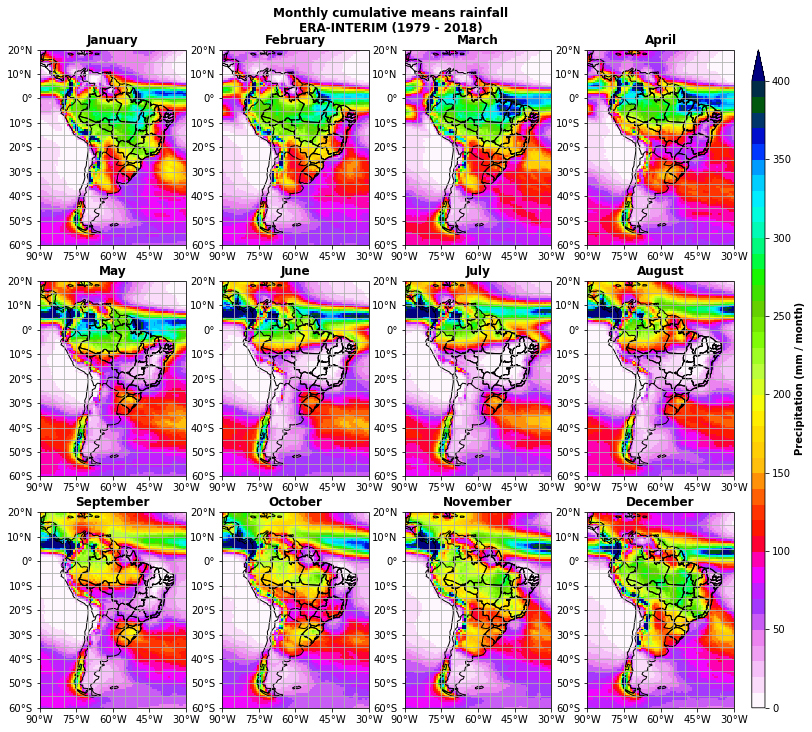

In [20]:
%%time

# Grid of maps.
axgr = cdlearn.maps.south_america_months(
    title="Monthly cumulative means rainfall\nERA-INTERIM (1979 - 2018)"
)

# Plot data on these maps.
for index, axis in enumerate(axgr):

    # Data limits.
    vmin = 0; vmax = 400; dv = 20
    
    plotmap = DA_mm.isel(month=index).plot(
        ax=axis,
        vmin=vmin,
        vmax=vmax,
        levels=np.arange(vmin, vmax + dv/2, dv/2),
        cmap=plt.cm.gist_ncar_r,
        add_colorbar=False,
        add_labels=False
    )
    
# Fill common colorbar.   
cb = plt.colorbar(plotmap, cax=axgr.cbar_axes[0], orientation="vertical")    
cb.set_label("Precipitation (mm / month)", weight="bold")

# Save figures.
if save_fig:
    plt.savefig(
        FIG_FOLDER + "total_precipitation_era_monthly_climatology.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )    

## Long term trends

In [21]:
# Slope, intercept, r value, p value, and standard error for linear regression. Annual trends.
DS_TRENDS_ANU = cdlearn.statistics.linear_regression(
    data_set=DS_ANU,
    var_code="tp", 
    verbose=True
)

>>> Loop over grid points ...


 97% (8448 of 8667) |################### | Elapsed Time: 0:00:03 ETA:   0:00:00

In [22]:
# Slope, intercept, r value, p value, and standard error for linear regression. Monthly trends.
DS_TRENDS_MON = cdlearn.statistics.linear_regression(
    data_set=DS_MON,
    var_code="tp", 
    verbose=True
)

>>> Loop over grid points ...


 98% (8558 of 8667) |################### | Elapsed Time: 0:00:03 ETA:   0:00:00

In [23]:
# Slope, intercept, r value, p value, and standard error for linear regression. Semi-monthly trends.
DS_TRENDS_SMO = cdlearn.statistics.linear_regression(
    data_set=DS_SMO,
    var_code="tp", 
    verbose=True
)

>>> Loop over grid points ...


 97% (8448 of 8667) |################### | Elapsed Time: 0:00:03 ETA:   0:00:00

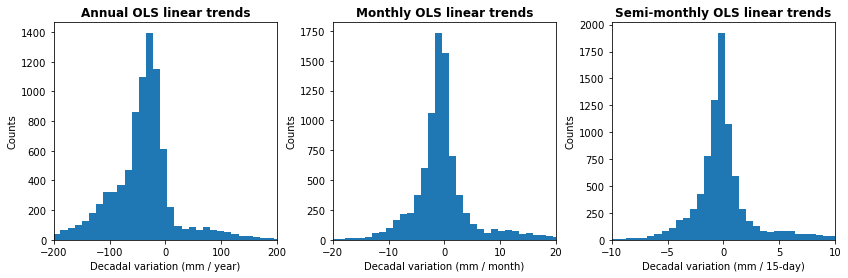

In [24]:
# Decadal variation.
fac_anu = 10
fac_mon = 120
fac_smo = 240

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
axes.flatten()
axes[0].hist(fac_anu * DS_TRENDS_ANU.slopes.values.flatten(), bins=200)
axes[1].hist(fac_mon * DS_TRENDS_MON.slopes.values.flatten(), bins=200)
axes[2].hist(fac_smo * DS_TRENDS_SMO.slopes.values.flatten(), bins=200)
axes[0].set_xlim((-200, 200)); axes[1].set_xlim((-20, 20)); axes[2].set_xlim((-10, 10))
axes[0].set_xlabel("Decadal variation (mm / year)"); axes[0].set_ylabel("Counts")
axes[1].set_xlabel("Decadal variation (mm / month)"); axes[1].set_ylabel("Counts")
axes[2].set_xlabel("Decadal variation (mm / 15-day)"); axes[2].set_ylabel("Counts")
axes[0].set_title("Annual OLS linear trends", weight="bold")
axes[1].set_title("Monthly OLS linear trends", weight="bold")
_ = axes[2].set_title("Semi-monthly OLS linear trends", weight="bold")
plt.subplots_adjust(wspace=0.25)

CPU times: user 576 ms, sys: 20 ms, total: 596 ms
Wall time: 598 ms


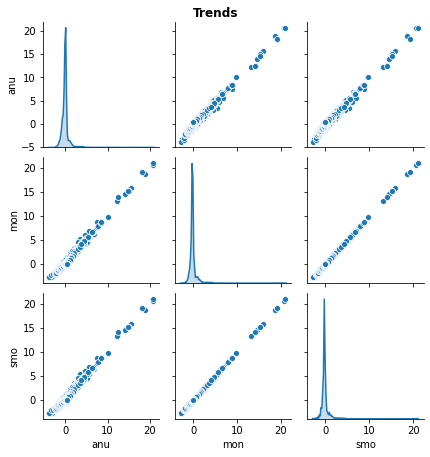

In [25]:
%%time

# Data.
data = np.vstack((
        fac_anu * DS_TRENDS_ANU.slopes.values.flatten(),
        fac_mon * DS_TRENDS_MON.slopes.values.flatten(),
        fac_smo * DS_TRENDS_SMO.slopes.values.flatten()
)).T

# Scale.
data = (data - data.mean(axis=0, keepdims=True)) / data.std(axis=0, keepdims=True)

# For pair plots.
df_trends = pd.DataFrame(data=data, columns=["anu", "mon", "smo"])

# Pair plots.
g = sns.pairplot(df_trends, diag_kind="kde", height=2.0)
_ = g.fig.suptitle("Trends", y=1.025, weight="bold")

CPU times: user 2.01 s, sys: 28 ms, total: 2.04 s
Wall time: 2.05 s


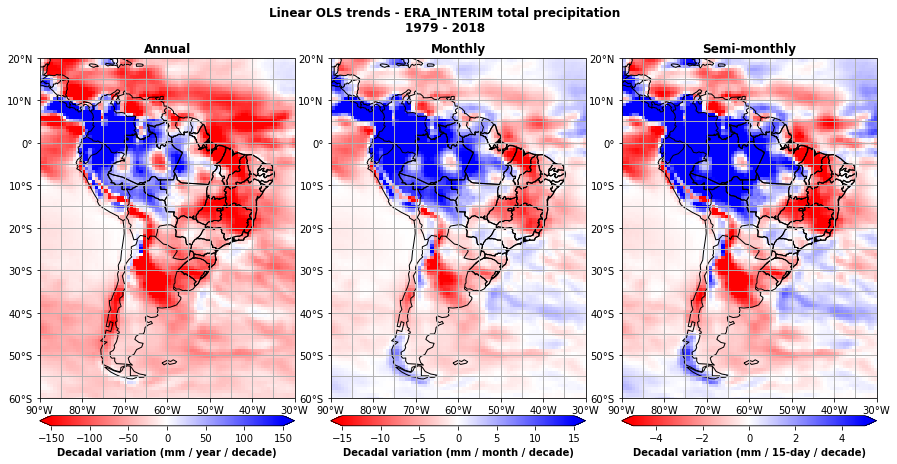

In [26]:
%%time

# Maps.
axgr = cdlearn.maps.south_america(
    figsize=(15, 12), 
    nrows_ncols=(1, 3),
    axes_pad=0.50,
    suptitle="Linear OLS trends - ERA_INTERIM total precipitation\n1979 - 2018",    
    suptitle_y=0.775,
    titles=["Annual", "Monthly", "Semi-monthly"],
    cbar_mode="each",
    cbar_location="bottom"
)

# Plot annual slopes.
plotmap = (fac_anu * DS_TRENDS_ANU.slopes).plot(
    ax=axgr[0],
    vmin=-150,
    vmax=150,
    cmap=plt.cm.bwr_r,
    add_colorbar=False,
    add_labels=False
)  

# Color bar.
cb = plt.colorbar(
    plotmap, 
    cax=axgr.cbar_axes[0], 
    orientation="horizontal", 
    extend="both",
    pad=0.50
)    
cb.set_label("Decadal variation (mm / year / decade)", weight="bold")

# Plot monthly slopes.
plotmap = (fac_mon * DS_TRENDS_MON.slopes).plot(
    ax=axgr[1],
    vmin=-15,
    vmax=15,
    cmap=plt.cm.bwr_r,
    add_colorbar=False,
    add_labels=False
)  

# Color bar.
cb = plt.colorbar(
    plotmap, 
    cax=axgr.cbar_axes[1], 
    orientation="horizontal", 
    extend="both",
    pad=0.50
)    
cb.set_label("Decadal variation (mm / month / decade)", weight="bold")

# Plot semi-monthly slopes.
plotmap = (fac_smo * DS_TRENDS_SMO.slopes).plot(
    ax=axgr[2],
    vmin=-5,
    vmax=5,
    cmap=plt.cm.bwr_r,
    add_colorbar=False,
    add_labels=False
)  

# Color bar.
cb = plt.colorbar(
    plotmap, 
    cax=axgr.cbar_axes[2], 
    orientation="horizontal", 
    extend="both",
    pad=0.50
)    
cb.set_label("Decadal variation (mm / 15-day / decade)", weight="bold")

# Save figures.
if save_fig:
    plt.savefig(
        FIG_FOLDER + "total_precipitation_era_trends.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )    